### Libraries

In [64]:
import math
import numpy as np

# import pandas 
# import plotly.express as px
import matplotlib.pyplot as plt

### Constants

In [65]:
# @title Gauss-Laguerre constants
# Notation: (weight, abscissa)
GAUSS_LAGUERRE = [
    (0.458964, 0.222847),
    (0.417, 1.188932),
    (0.113373, 2.992736),
    (0.0103992, 5.775144),
    (0.000261017, 9.837467),
    (0.000000898548, 15.982874)
]

GAUSS_LEGENDRE = [
    [0.2955242247147529, -0.1488743389816312],
    [0.2955242247147529, 0.1488743389816312],
    [0.2692667193099963, -0.4333953941292472],
    [0.2692667193099963, 0.4333953941292472],
    [0.2190863625159820, -0.6794095682990244],
    [0.2190863625159820, 0.6794095682990244],
    [0.1494513491505806, -0.8650633666889845],
    [0.1494513491505806, 0.8650633666889845],
    [0.0666713443086881, -0.9739065285171717],
    [0.0666713443086881, 0.9739065285171717]
]

### Functions

In [66]:
# @title Weibull distribution function
# Uses Gauss-Laguerre
def f_Weibull (t, k, mu):
    # f = lambda s, k : s ** (1/k)

    # denomArea = 0.0
    # for i in range(6):
    #     denomArea += GAUSS_LAGUERRE[i][0] * f(GAUSS_LAGUERRE[i][1], k)
    
    # lbda = mu / denomArea
    lbda = mu / 2

    return (k/lbda) * ((t/lbda) ** (k-1)) * (math.e ** (-(t/lbda) ** k))

In [67]:
# @title Integral of Weibull function
# using Gauss-Legendre; a=0, b=1
def cdf (t, k, mu):
    area = 0
    
    for i in range(10):
        s = t + 1 - (1/GAUSS_LEGENDRE[i][1])
        area += GAUSS_LEGENDRE[i][0] * f_Weibull(s, k, mu) / (GAUSS_LEGENDRE[i][1] ** 2)

    return 0.5 * area

In [68]:
# CDF plot
t_values = []
y_CDF = []

for t in range(1, 301, 1):
    t_values.append(t)
    y_CDF.append(cdf(t, 0.5, 78.0))

In [69]:
print(t_values)
print(y_CDF)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 22

c:\Users\joset\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\joset\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


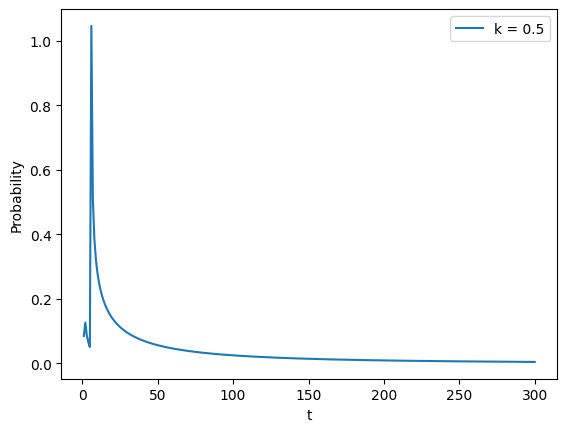

In [70]:
figures, axes = plt.subplots()
axes.plot(t_values, y_CDF, label="k = 0.5")
axes.set_xlabel("t")
axes.set_ylabel("Probability")
axes.legend()
plt.show()

In [71]:
# @title Inverse survivability
# solved as root-finding problem using bisection method
def surv_inv (alpha, a, b, k, mu):
    isDiffSign = lambda x1, x2 : np.sign(x1) != np.sign(x2)
    f = lambda t : cdf(t, k, mu) - alpha

    tol = 1.0e-9

    fa = f(a)
    fb = f(b)

    if fa == 0.0:
        return a
    
    if fb == 0.0:
        return b
    
    if not isDiffSign(fa, fb):
       print("---> Root not bracketed at", alpha)
       return None
    
    n = int (math.ceil (math.log(abs(b-a) / tol) / math.log(2.0)))

    for i in range(n):
        c = 0.5 * (a + b)
        fc = f(c)

        if (abs(fc) > abs(fa)) and (abs(fc) > abs(fb)):
            return None

        if fc == 0.0:
            return c

        if isDiffSign(fa, fc):
            a = c
            fa = fc
        
        elif isDiffSign(fb, fc):
            b = c
            fb = fc

    return 0.5 * (a+b)

### Evaluation

In [72]:
# Average life expectancy
expected_value = 78

# List for values
y_t_decr = []
y_t_cons = []
y_t_incr = []

x_values = []

In [73]:
# For alpha in (0,1) with 0.01 step
for alpha in range(1, 100, 1):
    alpha /= 100

    x_values.append(alpha)

    # y_t_decr.append(surv_inv(alpha, 0, 100, 0.5, expected_value))
    # y_t_cons.append(surv_inv(alpha, 0, 100, 1.0, expected_value))
    # y_t_incr.append(surv_inv(alpha, 0, 100, 2.0, expected_value))

### Plotting

ValueError: x and y must have same first dimension, but have shapes (99,) and (0,)

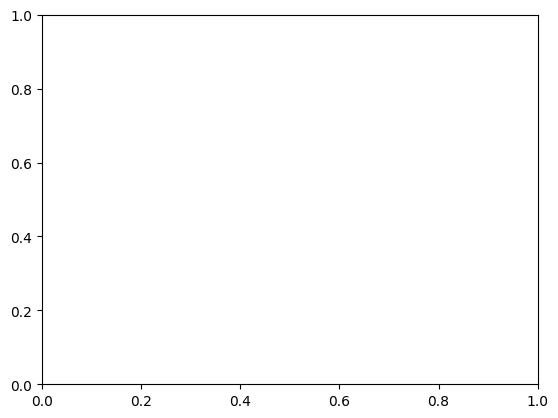

In [74]:
figures, axes = plt.subplots()

axes.plot(x_values, y_t_decr, label="k = 0.5")
axes.plot(x_values, y_t_cons, label="k = 1")
axes.plot(x_values, y_t_incr, label="k = 2")

axes.set_xlabel("Probability")
axes.set_ylabel("t")

axes.legend()

# plt.xticks(np.arange(0, 1, step=0.2))
# plt.yticks(np.arange(0, 100, step=10))

plt.show()